In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

import optuna

import lightgbm as lgb

In [2]:
df = pd.DataFrame()

l = ["data-2015.csv","data-2016.csv","data-2017.csv","data-2018.csv","data-2019.csv","data-2020.csv","data-2021.csv"]
for data in l:
    df_csv = pd.read_csv(f"data/{data}")
    df = pd.concat([df, df_csv])
df.index = np.arange(len(df))

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (95,96,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (33,34,44,45,48,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [277]:
list(df)

['num',
 'nom',
 'classement',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'ordreArrivee',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'tempsObtenu',
 'reductionKilometrique',
 'urlCasaque',
 'eleveur',
 'allure',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecede

In [171]:
list(df)

['num',
 'nom',
 'classement',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'deferre',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'allure',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typeRapport'

In [282]:
df["nbArrivé"]

0        11
1         7
2        12
3        12
4        11
         ..
87686    11
87687    12
87688    12
87689    11
87690     8
Name: nbArrivé, Length: 87691, dtype: int64

In [255]:
for i in range(1,3):
    df[f"M{i}"] = pd.to_numeric(df["music"].apply(lambda x: x.strip("[]").split(", ")[i])).replace(0,10)

In [257]:
df["M1"].unique()

array([ 3,  7,  1,  2, 10,  4,  6,  8,  9,  5], dtype=int64)

In [3]:
features = ['num',
 'classement',
 'id',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 "dernierRapportDirect_nombreIndicateurTendance",
 "dernierRapportReference_indicateurTendance",
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_rapport',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [277]:
df_train["dernierRapportReference_indicateurTendance"].unique()

array([ 1.,  0., -1.])

In [4]:
df_train = df.loc[:][features]
df_train["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4', 'R8', 'G6'], 10, inplace=True)

df_train["classement"] = (
    pd.to_numeric(df_train["classement"],
                  errors='coerce')
      .fillna(10))



df_train["dernierRapportReference_indicateurTendance"] = df_train["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)

df_train["classement"] = df_train["classement"].replace(0.,10.)

In [10]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_train, groups=df_train['id'])

X_train_inds, X_test_inds = next(gss)

train_data= df_train.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['id','classement'])]
y_train = train_data.loc[:, train_data.columns.isin(['classement'])]

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

test_data = df_train.loc[:].iloc[X_test_inds]
test_data.apply(pd.to_numeric, errors='ignore')

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['id','classement'])]
y_test = test_data.loc[:, test_data.columns.isin(['classement'])]

test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()

In [37]:
len(y_test)

57721

# Hyperparameter

In [79]:
from optuna.integration import LightGBMPruningCallback
from scipy import stats
import sklearn.metrics

def objective(trial):
    param_grid = {
    #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_int("n_estimators", 100,500,step=100),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", -1, 500, 50),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    }
    model = lgb.LGBMRanker(n_jobs=24,objective="lambdarank",boosting_type = "gbdt",metric= "ndcg", **param_grid)
    model.fit(
        X_train,
        y_train.astype(np.int32),
        group = groups,
        eval_set=[(X_test, y_test)],
        eval_group = [test_groups],
        eval_metric="ndcg",
        early_stopping_rounds=100,
        verbose=False
    )
    preds = model.predict(X_test)
    test_data["rank_pred"] = predictions
    test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
    test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

    test_data["classement"] = test_data["classement"].apply(pd.to_numeric)
    
    return len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

In [80]:
study = optuna.create_study(direction="maximize", study_name="LGBM Ranker")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=50)

[I 2022-11-12 23:39:14,123] A new study created in memory with name: LGBM Ranker
[I 2022-11-12 23:39:15,494] Trial 0 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.1476366795580806, 'num_leaves': 3000, 'max_depth': 499, 'min_data_in_leaf': 9900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-pac

[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100


[I 2022-11-12 23:39:17,453] Trial 1 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.14950265792048356, 'num_leaves': 1320, 'max_depth': 349, 'min_data_in_leaf': 6100}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000


[I 2022-11-12 23:39:19,482] Trial 2 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.06098072303795578, 'num_leaves': 580, 'max_depth': 399, 'min_data_in_leaf': 8000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800


[I 2022-11-12 23:39:22,829] Trial 3 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.03542833161614938, 'num_leaves': 2040, 'max_depth': 499, 'min_data_in_leaf': 9800}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600


[I 2022-11-12 23:39:24,983] Trial 4 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.1853935200415455, 'num_leaves': 340, 'max_depth': -1, 'min_data_in_leaf': 2600}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and wi

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600


[I 2022-11-12 23:39:28,519] Trial 5 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.10291743955571668, 'num_leaves': 1260, 'max_depth': 299, 'min_data_in_leaf': 600}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300


[I 2022-11-12 23:39:30,778] Trial 6 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.0840722341913762, 'num_leaves': 1980, 'max_depth': 299, 'min_data_in_leaf': 8300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000


[I 2022-11-12 23:39:32,762] Trial 7 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.11114505085644799, 'num_leaves': 2820, 'max_depth': 399, 'min_data_in_leaf': 4000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300


[I 2022-11-12 23:39:34,478] Trial 8 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.15649812549913525, 'num_leaves': 720, 'max_depth': 299, 'min_data_in_leaf': 7300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800


[I 2022-11-12 23:39:36,141] Trial 9 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.1354328961486179, 'num_leaves': 960, 'max_depth': 99, 'min_data_in_leaf': 2800}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and wi

[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000


[I 2022-11-12 23:39:37,533] Trial 10 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.2732165315267, 'num_leaves': 2820, 'max_depth': 149, 'min_data_in_leaf': 10000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and w

[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100


[I 2022-11-12 23:39:39,545] Trial 11 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.2152550814587728, 'num_leaves': 1800, 'max_depth': 499, 'min_data_in_leaf': 6100}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400


[I 2022-11-12 23:39:41,221] Trial 12 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.23049441581322153, 'num_leaves': 2380, 'max_depth': 399, 'min_data_in_leaf': 5400}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600


[I 2022-11-12 23:39:42,868] Trial 13 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.15927223673012975, 'num_leaves': 1400, 'max_depth': 449, 'min_data_in_leaf': 6600}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400


[I 2022-11-12 23:39:44,354] Trial 14 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.2088774036453553, 'num_leaves': 40, 'max_depth': 249, 'min_data_in_leaf': 4400}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and w

[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000


[I 2022-11-12 23:39:46,121] Trial 15 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.26550949321832096, 'num_leaves': 2320, 'max_depth': 199, 'min_data_in_leaf': 9000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


[I 2022-11-12 23:39:52,236] Trial 16 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.13885280394232624, 'num_leaves': 1560, 'max_depth': 349, 'min_data_in_leaf': 200}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400


[I 2022-11-12 23:39:53,650] Trial 17 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.20475291785118374, 'num_leaves': 180, 'max_depth': 199, 'min_data_in_leaf': 4400}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100


[I 2022-11-12 23:39:55,493] Trial 18 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.2786288336658377, 'num_leaves': 2480, 'max_depth': 49, 'min_data_in_leaf': 9100}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


[I 2022-11-12 23:39:58,731] Trial 19 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.1190815547801759, 'num_leaves': 2980, 'max_depth': 449, 'min_data_in_leaf': 1000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100


[I 2022-11-12 23:40:00,216] Trial 20 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.19779205332556227, 'num_leaves': 20, 'max_depth': 199, 'min_data_in_leaf': 3100}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000


[I 2022-11-12 23:40:01,571] Trial 21 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.2445723812046241, 'num_leaves': 2480, 'max_depth': -1, 'min_data_in_leaf': 9000}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300


[I 2022-11-12 23:40:05,021] Trial 22 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.013017586998734593, 'num_leaves': 3000, 'max_depth': 49, 'min_data_in_leaf': 1300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100


[I 2022-11-12 23:40:07,172] Trial 23 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.18418142515515545, 'num_leaves': 2980, 'max_depth': 499, 'min_data_in_leaf': 2100}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600


[I 2022-11-12 23:40:08,775] Trial 24 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.24353086981782407, 'num_leaves': 2640, 'max_depth': -1, 'min_data_in_leaf': 3600}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700


[I 2022-11-12 23:40:10,956] Trial 25 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.29946751289148543, 'num_leaves': 2620, 'max_depth': 99, 'min_data_in_leaf': 1700}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700


[I 2022-11-12 23:40:15,935] Trial 26 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.02450952027506681, 'num_leaves': 2960, 'max_depth': 499, 'min_data_in_leaf': 1700}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400


[I 2022-11-12 23:40:17,721] Trial 27 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.17845532692835492, 'num_leaves': 2700, 'max_depth': 449, 'min_data_in_leaf': 3400}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900


[I 2022-11-12 23:40:19,268] Trial 28 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.2510670230431427, 'num_leaves': 2200, 'max_depth': 99, 'min_data_in_leaf': 3900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300


[I 2022-11-12 23:40:21,968] Trial 29 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.0695395643720847, 'num_leaves': 2680, 'max_depth': 349, 'min_data_in_leaf': 2300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300


[I 2022-11-12 23:40:24,040] Trial 30 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.16735993317683215, 'num_leaves': 1760, 'max_depth': 449, 'min_data_in_leaf': 5300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500


[I 2022-11-12 23:40:28,363] Trial 31 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.030740611916467833, 'num_leaves': 2180, 'max_depth': 499, 'min_data_in_leaf': 3500}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated a

[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900


[I 2022-11-12 23:40:31,028] Trial 32 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.05537880615107756, 'num_leaves': 2680, 'max_depth': 349, 'min_data_in_leaf': 4900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400


[I 2022-11-12 23:40:33,672] Trial 33 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.06104834712636594, 'num_leaves': 1780, 'max_depth': 399, 'min_data_in_leaf': 5400}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300


[I 2022-11-12 23:40:36,342] Trial 34 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.08074770498624634, 'num_leaves': 1880, 'max_depth': 449, 'min_data_in_leaf': 2300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700


[I 2022-11-12 23:40:37,696] Trial 35 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.11836383754964927, 'num_leaves': 1080, 'max_depth': 249, 'min_data_in_leaf': 8700}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500


[I 2022-11-12 23:40:38,966] Trial 36 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.19868507521636278, 'num_leaves': 440, 'max_depth': 49, 'min_data_in_leaf': 7500}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500


[I 2022-11-12 23:40:40,973] Trial 37 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.2293260645625298, 'num_leaves': 2480, 'max_depth': -1, 'min_data_in_leaf': 9500}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and 

[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200


[I 2022-11-12 23:40:42,768] Trial 38 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.18313053689296444, 'num_leaves': 3000, 'max_depth': 49, 'min_data_in_leaf': 8200}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300


[I 2022-11-12 23:40:45,917] Trial 39 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.09914436012075976, 'num_leaves': 2840, 'max_depth': -1, 'min_data_in_leaf': 1300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800


[I 2022-11-12 23:40:49,503] Trial 40 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 300, 'learning_rate': 0.04630730463876534, 'num_leaves': 2840, 'max_depth': 49, 'min_data_in_leaf': 1800}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900


[I 2022-11-12 23:40:51,629] Trial 41 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.25844306680240287, 'num_leaves': 2640, 'max_depth': 99, 'min_data_in_leaf': 1900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800


[I 2022-11-12 23:40:53,646] Trial 42 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.29898111197693905, 'num_leaves': 2580, 'max_depth': 499, 'min_data_in_leaf': 1800}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700


[I 2022-11-12 23:40:56,381] Trial 43 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.28522245701565785, 'num_leaves': 2860, 'max_depth': 499, 'min_data_in_leaf': 700}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900


[I 2022-11-12 23:40:58,031] Trial 44 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.29664865047531214, 'num_leaves': 2220, 'max_depth': 449, 'min_data_in_leaf': 2900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300


[I 2022-11-12 23:41:00,150] Trial 45 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 400, 'learning_rate': 0.23326809995502723, 'num_leaves': 2740, 'max_depth': 149, 'min_data_in_leaf': 3300}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900


[I 2022-11-12 23:41:01,864] Trial 46 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 200, 'learning_rate': 0.25376645684508686, 'num_leaves': 2020, 'max_depth': 149, 'min_data_in_leaf': 3900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900


[I 2022-11-12 23:41:03,288] Trial 47 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 100, 'learning_rate': 0.17081100546034642, 'num_leaves': 2200, 'max_depth': 99, 'min_data_in_leaf': 5900}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and

[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500


[I 2022-11-12 23:41:06,283] Trial 48 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.07471823408585171, 'num_leaves': 2300, 'max_depth': 399, 'min_data_in_leaf': 2500}. Best is trial 0 with value: 0.3278767453057294.
C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated an

[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500


[I 2022-11-12 23:41:08,161] Trial 49 finished with value: 0.3278767453057294 and parameters: {'n_estimators': 500, 'learning_rate': 0.14235886242886547, 'num_leaves': 2760, 'max_depth': 349, 'min_data_in_leaf': 4500}. Best is trial 0 with value: 0.3278767453057294.


In [81]:
print('Number of finished trials:', len(study.trials))
print('Best Correlation', study.best_value)
print('Best trial:', study.best_trial.params)

Number of finished trials: 50
Best Correlation 0.3278767453057294
Best trial: {'n_estimators': 100, 'learning_rate': 0.1476366795580806, 'num_leaves': 3000, 'max_depth': 499, 'min_data_in_leaf': 9900}


In [74]:
gbm = lgb.LGBMRanker(objective="lambdarank",
                    boosting_type = "gbdt",
                    importance_type = "split",
                    metric= "ndcg",
                    **study.best_trial.params)

ValueError: No trials are completed yet.

In [65]:
gbm.fit(X_train, y_train.astype(np.int32), group=groups)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2823013796121562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2823013796121562
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRanker(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
           lambda_l1=0, lambda_l2=40, learning_rate=0.06509791773699271,
           max_bin=223, metric='ndcg', min_data_in_leaf=900,
           min_gain_to_split=0.2823013796121562, n_estimators=200,
           num_leaves=1280, objective='lambdarank')

In [43]:
predictions = loaded_model.predict(X_test)
test_data["rank_pred"] = predictions
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

test_data["classement"] = test_data["classement"].apply(pd.to_numeric)

NameError: name 'X_test' is not defined

In [67]:
test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]

0.551929321773185

In [68]:
len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

0.3278767453057294

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

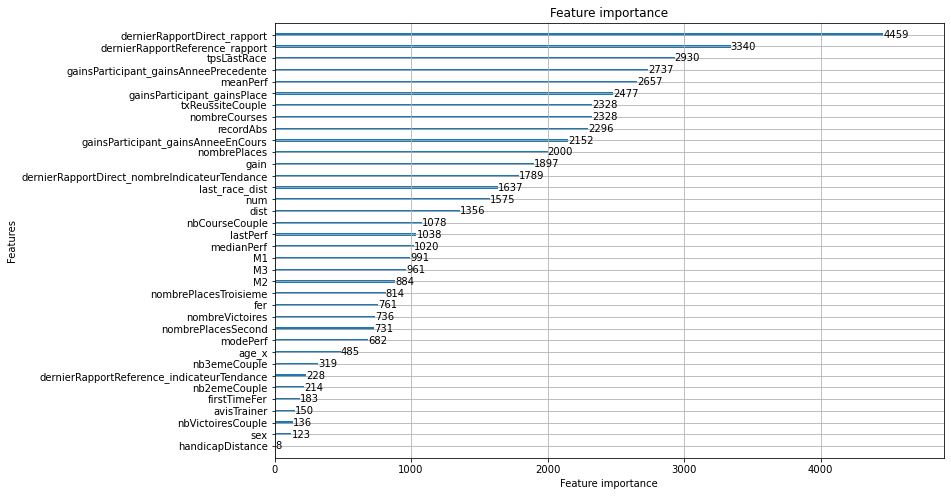

In [264]:
lgb.plot_importance(gbm, figsize = (12,8))

In [344]:
gbm.booster_.save_model("models/modelv1.txt")

In [363]:
def get_proba(rapport_min,rapport_max):
    p = len(test_data.loc[test_data["dernierRapportDirect_rapport"] <= rapport_max].loc[test_data["dernierRapportDirect_rapport"] >= rapport_min].loc[test_data["rank_pred"] == 1].loc[test_data["classement"]==1]) / len(test_data.loc[test_data["dernierRapportDirect_rapport"] <= rapport_max].loc[test_data["dernierRapportDirect_rapport"] > rapport_min].loc[test_data["rank_pred"] == 1])
    return p

In [364]:
get_proba(20,30)

0.2914798206278027

In [302]:
class_rapport = np.arange(5,50,5)
nb_victoire = []
for i in class_rapport:
    nb_victoire.append( len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].loc[test_data["dernierRapportDirect_rapport"] < i ]) - sum(nb_victoire))

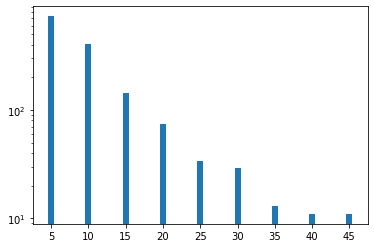

In [303]:
plt.bar(class_rapport,nb_victoire)
plt.yscale("log")

In [304]:
test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].dernierRapportDirect_rapport.describe()

count    1477.000000
mean        8.481855
std        11.603491
min         1.100000
25%         2.900000
50%         5.000000
75%         9.300000
max       165.000000
Name: dernierRapportDirect_rapport, dtype: float64

In [370]:
argent = 100
wins, loses = 0, 0

evo = [100]
for name,group in test_data.groupby("id"):
    cote = group.loc[group["rank_pred"] == 1]["dernierRapportDirect_rapport"].values[0]
    
    if not np.isnan(cote):
        f_kelly = kelly(cote, argent, get_proba(cote-5,cote+5))
        if group.loc[group["rank_pred"] == 1]["classement"].values[0] == 1:
            argent += cote * f_kelly*argent
            wins+=1
        else:
            argent -= f_kelly*argent
            loses +=1
        evo += [argent]

<ipython-input-370-209bb6d4ee18>:11: RuntimeWarning: overflow encountered in double_scalars
  argent += cote * f_kelly*argent
<ipython-input-370-209bb6d4ee18>:14: RuntimeWarning: invalid value encountered in double_scalars
  argent -= f_kelly*argent


In [369]:
print(argent)
x = np.arange(len(evo))
a,b = np.polyfit(x, evo, 1)

nan


LinAlgError: SVD did not converge in Linear Least Squares

In [371]:
evo

[100,
 66.81869682945097,
 44.4097109273812,
 30.282347943507872,
 20.569448074122395,
 14.220341789332757,
 10.330751584373031,
 7.447531506561203,
 5.547032223660887,
 4.078491000345537,
 2.8493396668062863,
 2.1406705919217477,
 1.5264938702121595,
 0.9973610052746354,
 0.6689008351838851,
 0.45210729035045083,
 0.32397768567000845,
 0.5404775499737986,
 0.39264452208162176,
 1.3863533174128877,
 0.9066281332053002,
 0.666904988572487,
 1.0787132107328166,
 0.7776540320288818,
 0.559847679155752,
 4.798694392763587,
 3.3963109699935834,
 2.208069941924203,
 1.6053569730826478,
 1.2446643137563687,
 0.8724176038622028,
 10.955942001990454,
 8.054772790868164,
 5.9249961029297875,
 4.30437353648291,
 3.08449123996209,
 2.166107456667729,
 6.955008056977844,
 5.291944114909797,
 11.5481578244218,
 7.663045850861112,
 25.723405373827966,
 17.22514538117484,
 12.049335422836325,
 53.52847908563325,
 38.8915464826006,
 26.619274479809878,
 19.353299047820958,
 134.32111124856687,
 96.0449

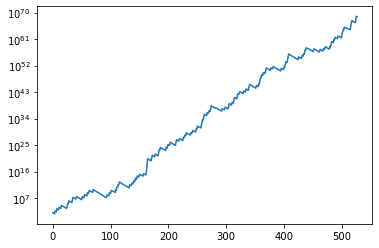

In [367]:
plt.plot(evo)
# plt.plot(a*x+b)
plt.yscale("log")

In [34]:
y_test

,classement
36,3
37,2
38,4
39,6
40,10
...,...
32687,5
32688,0
32689,10
32690,1


In [59]:
list(X_test)

35

In [4]:
features_pred = ['num',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 "dernierRapportDirect_nombreIndicateurTendance",
 "dernierRapportReference_indicateurTendance",
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_rapport',
 'dernierRapportReference_rapport',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

# Prédictions

In [2]:
loaded_model = lgb.Booster(model_file="models/modelv1.txt")

In [1]:
today = pd.read_csv("vincenne.csv", index_col=0)
today_feat = today.loc[:][features_pred]
today_feat["dernierRapportReference_indicateurTendance"] = today_feat["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)
today_feat = today_feat.apply(pd.to_numeric, errors="coerce")
today_feat

NameError: name 'pd' is not defined

In [31]:
today.loc[today["numCoursePMU"] == "R10C3"]["dernierRapportDirect_rapport"]

0     29.5
1     61.1
2     67.3
3      6.3
4      3.8
5     68.7
6      7.7
7      6.5
8     41.1
9      5.0
10    31.3
11     8.0
Name: dernierRapportDirect_rapport, dtype: float64

In [151]:
list(today)

['num',
 'nom',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'eleveur',
 'allure',
 'avisEntraineur',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRappor

In [45]:
pred_today = loaded_model.predict(today_feat)

In [46]:
today["pred"] = pred_today
today['pred'] = today.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
today['pred'] = today.groupby("id")["pred"].rank("first").astype(int)

In [11]:
today.sort_values(by="pred")[["num", "nom", "pred"]]

,num,nom,pred
12,13,HAPUNA BEACH,1
9,10,FILOU DE L'ELLE,1
9,10,JEMILLIA BELLA,1
1,2,I LOVE JAM,1
11,12,HELIO VAINE,1
...,...,...,...
15,16,EXPERT CASTELETS,16
1,2,FLORE MERITE,16
13,14,FOLIE BLONDE,17
13,14,FLORA VENESI,17


In [160]:
groupe_len = today[["num", "nom","pred","id","url"]].groupby("id").size()

In [49]:
winners = today[["numCoursePMU","num", "nom","dernierRapportReference_rapport","pred"]].loc[today["pred"]==1]
winners

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
10,R4C1,11,ETINCELLE DE NIEUL,24.0,1
3,R4C4,4,IN BEETWEEN US,8.5,1
9,R4C8,10,JEMILLIA BELLA,13.0,1


In [36]:
winners = winners.dropna()
winners

,numCoursePMU,num,nom,dernierRapportDirect_rapport,pred
10,R4C1,11,ETINCELLE DE NIEUL,24.0,1
3,R4C4,4,IN BEETWEEN US,8.5,1
9,R4C8,10,JEMILLIA BELLA,13.0,1
1,R10C3,2,I LOVE JAM,61.1,1
7,R10C4,8,INSTINCT DU RENARD,9.6,1
12,R10C5,13,FEDORA DU CHATELET,7.5,1
5,R10C8,6,FOREVER DES NOELS,9.0,1
5,R13C3,6,IRENE FLASH,2.6,1


In [37]:
def kelly(rapport, capital, p):
    return p-(1-p)/rapport

In [42]:
capital = 20
winners["mises"] = winners["dernierRapportDirect_rapport"].apply(lambda x: kelly(x, capital, 0.3) * capital)
winners

<ipython-input-42-352da2f34dbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners["mises"] = winners["dernierRapportDirect_rapport"].apply(lambda x: kelly(x, capital, 0.3) * capital)


,numCoursePMU,num,nom,dernierRapportDirect_rapport,pred,mises
10,R4C1,11,ETINCELLE DE NIEUL,24.0,1,5.416667
3,R4C4,4,IN BEETWEEN US,8.5,1,4.352941
9,R4C8,10,JEMILLIA BELLA,13.0,1,4.923077
1,R10C3,2,I LOVE JAM,61.1,1,5.770867
7,R10C4,8,INSTINCT DU RENARD,9.6,1,4.541667
12,R10C5,13,FEDORA DU CHATELET,7.5,1,4.133333
5,R10C8,6,FOREVER DES NOELS,9.0,1,4.444444
5,R13C3,6,IRENE FLASH,2.6,1,0.615385


In [139]:
winners["mises"] * winners["dernierRapportDirect_rapport"]

11     28.188602
10     16.208354
0     150.000000
13     77.932422
10     20.670172
11    144.349776
6      31.152423
dtype: float64

In [142]:
winners["mises"].sum()

23.95458126218623